In [1]:
#require tensorflow version
# Same as EQpolarity env
# conda create -n eqp python=3.11.7
# conda activate eqp
# conda install ipython notebook
# pip install matplotlib==3.8.0 tensorflow==2.14.0 scikit-learn==1.2.2 seaborn==0.13.2 
#
# Or, on machine with a GPU setup, use the following commands
# 
# conda create -n eqp python=3.10.14
# conda activate eqp
# conda install ipython notebook
# pip install matplotlib==3.8.0 tensorflow==2.11.0 scikit-learn==1.2.2 seaborn==0.13.2 
# conda install -c anaconda cudnn==8.2.1

from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import h5py
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,LearningRateScheduler

from tensorflow.keras.layers import *
import numpy as np
from matplotlib import pylab as plt
from keras import backend as K
from tensorflow.keras.models import Model
import tensorflow as tf
from matplotlib.colors import ListedColormap

def patch3d(A, l1=4, l2=4, l3=4, s1=2, s2=2, s3=2):
    """
    Optimized patch3d function using stride tricks to improve efficiency
    """
    # Pad the array if necessary to ensure dimensions are divisible by patch sizes
    pad1 = (l1 - A.shape[0] % s1) % s1
    pad2 = (l2 - A.shape[1] % s2) % s2
    pad3 = (l3 - A.shape[2] % s3) % s3
    A_padded = np.pad(A, ((0, pad1), (0, pad2), (0, pad3)), mode='constant')

    # Get new dimensions
    n1, n2, n3 = A_padded.shape
    n1_patches = (n1 - l1) // s1 + 1
    n2_patches = (n2 - l2) // s2 + 1
    n3_patches = (n3 - l3) // s3 + 1

    # Generate the sliding window view
    shape = (n1_patches, n2_patches, n3_patches, l1, l2, l3)
    strides = (s1 * A_padded.strides[0], s2 * A_padded.strides[1], s3 * A_padded.strides[2]) + A_padded.strides
    patches = np.lib.stride_tricks.as_strided(A_padded, shape=shape, strides=strides)

    # Reshape patches to (num_patches, patch_size) format
    patches = patches.reshape(-1, l1 * l2 * l3)
    return patches


def patch3d_inv(X, n1, n2, n3, l1=4, l2=4, l3=4, s1=2, s2=2, s3=2):
    """
    Reconstruct 3D data from 1D patches with optimized inverse patching.

    INPUT
    X: Patches in (num_patches, patch_size) format
    n1, n2, n3: Original 3D data dimensions
    l1, l2, l3: Patch sizes along each dimension
    s1, s2, s3: Shifts between patches along each dimension

    OUTPUT
    A: Reconstructed 3D data
    """

    # Initialize the padded 3D array and mask
    pad1 = (l1 - n1 % s1) % s1
    pad2 = (l2 - n2 % s2) % s2
    pad3 = (l3 - n3 % s3) % s3
    A = np.zeros((n1 + pad1, n2 + pad2, n3 + pad3))
    mask = np.zeros_like(A)

    # Reshape 1D patches to the 3D patch size for easier handling
    X = X.reshape(-1, l1, l2, l3)

    # Calculate the number of patches along each dimension
    n1_patches = (A.shape[0] - l1) // s1 + 1
    n2_patches = (A.shape[1] - l2) // s2 + 1
    n3_patches = (A.shape[2] - l3) // s3 + 1

    # Iterate over each patch and place it into the appropriate location
    idx = 0
    for i in range(n1_patches):
        for j in range(n2_patches):
            for k in range(n3_patches):
                # Place the current patch in the reconstruction array and update mask
                A[i * s1:i * s1 + l1, j * s2:j * s2 + l2, k * s3:k * s3 + l3] += X[idx]
                mask[i * s1:i * s1 + l1, j * s2:j * s2 + l2, k * s3:k * s3 + l3] += 1
                idx += 1

    # Avoid division by zero by replacing zeros with ones in the mask before division
    mask[mask == 0] = 1
    A /= mask

    # Trim padding to match the original dimensions
    return A[:n1, :n2, :n3]


from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np


def cseis():
    '''
    cseis: seismic colormap

    By Yangkang Chen
    June, 2022

    EXAMPLE
    from pyseistr import cseis
    import numpy as np
    from matplotlib import pyplot as plt
    plt.imshow(np.random.randn(100,100),cmap=cseis())
    plt.show()
    '''
    seis = np.concatenate(
        (np.concatenate((0.5 * np.ones([1, 40]), np.expand_dims(np.linspace(0.5, 1, 88), axis=1).transpose(),
                         np.expand_dims(np.linspace(1, 0, 88), axis=1).transpose(), np.zeros([1, 40])),
                        axis=1).transpose(),
         np.concatenate((0.25 * np.ones([1, 40]), np.expand_dims(np.linspace(0.25, 1, 88), axis=1).transpose(),
                         np.expand_dims(np.linspace(1, 0, 88), axis=1).transpose(), np.zeros([1, 40])),
                        axis=1).transpose(),
         np.concatenate((np.zeros([1, 40]), np.expand_dims(np.linspace(0, 1, 88), axis=1).transpose(),
                         np.expand_dims(np.linspace(1, 0, 88), axis=1).transpose(), np.zeros([1, 40])),
                        axis=1).transpose()), axis=1)

    return ListedColormap(seis)


def plot3d(d3d, frames=None, z=None, x=None, y=None, dz=0.01, dx=0.01, dy=0.01, nlevel=100, figsize=(8, 6),
           ifnewfig=True, figname=None, showf=True, close=True, **kwargs):
    '''
    plot3d: plot beautiful 3D slices

    INPUT
    d3d: input 3D data (z in first-axis, x in second-axis, y in third-axis)
    frames: plotting slices on three sides (default: [nz/2,nx/2,ny/2])
    z,x,y: axis vectors  (default: 0.01*[np.arange(nz),np.arange(nx),np.arange(ny)])
    figname: figure name to be saved (default: None)
    showf: if show the figure (default: True)
    close: if not show a figure, if close the figure (default: True)
    kwargs: other specs for plotting
    dz,dx,dy: interval (default: 0.01)

    By Yangkang Chen
    June, 18, 2023

    EXAMPLE 1
    import numpy as np
    d3d=np.random.rand(100,100,100);
    from pyseistr import plot3d
    plot3d(d3d);

    EXAMPLE 2
    import scipy
    data=scipy.io.loadmat('/Users/chenyk/chenyk/matlibcyk/test/hyper3d.mat')['cmp']
    from pyseistr import plot3d
    plot3d(data);

    EXAMPLE 3
    import numpy as np
    import matplotlib.pyplot as plt
    from pyseistr import plot3d

    nz=81
    nx=81
    ny=81
    dz=20
    dx=20
    dy=20
    nt=1501
    dt=0.001

    v=np.arange(nz)*20*1.2+1500;
    vel=np.zeros([nz,nx,ny]);
    for ii in range(nx):
        for jj in range(ny):
            vel[:,ii,jj]=v;

    plot3d(vel,figsize=(16,10),cmap=plt.cm.jet,z=np.arange(nz)*dz,x=np.arange(nx)*dx,y=np.arange(ny)*dy,barlabel='Velocity (m/s)',showf=False,close=False)
    plt.gca().set_xlabel("X (m)",fontsize='large', fontweight='normal')
    plt.gca().set_ylabel("Y (m)",fontsize='large', fontweight='normal')
    plt.gca().set_zlabel("Z (m)",fontsize='large', fontweight='normal')
    plt.title('3D velocity model')
    plt.savefig(fname='vel3d.png',format='png',dpi=300)
    plt.show()

    '''

    [nz, nx, ny] = d3d.shape;

    if frames is None:
        frames = [int(nz / 2), int(nx / 2), int(ny / 2)]

    if z is None:
        z = np.arange(nz) * dz

    if x is None:
        x = np.arange(nx) * dx

    if y is None:
        y = np.arange(ny) * dy

    X, Y, Z = np.meshgrid(x, y, z)

    d3d = d3d.transpose([1, 2, 0])

    kw = {
        'vmin': d3d.min(),
        'vmax': d3d.max(),
        'levels': np.linspace(d3d.min(), d3d.max(), nlevel),
        'cmap': cseis()
    }

    kw.update(kwargs)

    if 'alpha' not in kw.keys():
        kw['alpha'] = 1.0

    if ifnewfig == False:
        ax = plt.gca()
    else:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, aspect='auto', projection='3d')
        plt.jet()

    # Plot contour surfaces
    _ = ax.contourf(
        X[:, :, -1], Y[:, :, -1], d3d[:, :, frames[0]].transpose(),  # x,y,z
        zdir='z', offset=0, **kw
    )

    _ = ax.contourf(
        X[0, :, :], d3d[:, frames[2], :], Z[0, :, :],
        zdir='y', offset=Y.min(), **kw
    )

    C = ax.contourf(
        d3d[frames[1], :, :], Y[:, -1, :], Z[:, -1, :],
        zdir='x', offset=X.max(), **kw
    )

    plt.gca().set_xlabel("X", fontsize='large', fontweight='normal')
    plt.gca().set_ylabel("Y", fontsize='large', fontweight='normal')
    plt.gca().set_zlabel("Z", fontsize='large', fontweight='normal')

    xmin, xmax = X.min(), X.max()
    ymin, ymax = Y.min(), Y.max()
    zmin, zmax = Z.min(), Z.max()
    ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])
    plt.gca().invert_zaxis()

    # Colorbar
    if 'barlabel' in kw.keys():
        cbar = fig.colorbar(C, ax=ax, orientation='horizontal', fraction=0.02, pad=0.1, format="%.2f",
                            label=kw['barlabel'])
        cbar.ax.locator_params(nbins=5)
        kwargs.__delitem__('barlabel')

    if figname is not None:
        if 'cmap' in kwargs.keys():
            kwargs.__delitem__('cmap')
        plt.savefig(figname, **kwargs)

    if showf:
        plt.show()
    else:
        if close:
            plt.close()  # or plt.clear() ?


def framebox(x1, x2, y1, y2, c=None, lw=None):
    '''
    framebox: for drawing a frame box

    By Yangkang Chen
    June, 2022

    INPUT
    x1,x2,y1,y2: intuitive

    EXAMPLE I
    from pyseistr.plot import framebox
    from pyseistr.synthetics import gensyn
    from matplotlib import pyplot as plt
    d=gensyn();
    plt.imshow(d);
    framebox(200,400,200,300);
    plt.show()

    EXAMPLE II
    from pyseistr.plot import framebox
    from pyseistr.synthetics import gensyn
    from matplotlib import pyplot as plt
    d=gensyn();
    plt.imshow(d);
    framebox(200,400,200,300,c='g',lw=4);
    plt.show()

    '''

    if c is None:
        c = 'r';
    if lw is None:
        lw = 2;

    plt.plot([x1, x2], [y1, y1], linestyle='-', color=c, linewidth=lw);
    plt.plot([x1, x2], [y2, y2], linestyle='-', color=c, linewidth=lw);
    plt.plot([x1, x1], [y1, y2], linestyle='-', color=c, linewidth=lw);
    plt.plot([x2, x2], [y1, y2], linestyle='-', color=c, linewidth=lw);

    return


# def huber_loss_mean(y_true, y_pred, clip_delta=1.3):
def huber_loss_mean(y_true, y_pred, clip_delta=2):
    error = y_true - y_pred
    abs_error = tf.keras.backend.abs(error)

    squared_loss = 0.5 * tf.keras.backend.square(error)
    linear_loss = clip_delta * (abs_error - 0.5 * clip_delta)

    return tf.keras.backend.mean(tf.where(abs_error < clip_delta, squared_loss, linear_loss))



def lr_schedule(epoch):
    initial_lr = 1e-3

    if epoch <= 20:
        lr = initial_lr
    elif epoch <= 40:
        lr = initial_lr / 2
    elif epoch <= 60:
        lr = 3e-4
    elif epoch <= 80:
        lr = initial_lr / 10
    else:
        lr = initial_lr / 20
   # print('Learning rate: ', lr)
    return lr


def FEB(inpt_img,D1, dropout):
    C1 = Dense(D1)(inpt_img)
    C1 = LeakyReLU(0.01)(C1)
    C1 = BatchNormalization()(C1)
    C1 = Dropout(dropout)(C1)
    return C1

def MAB(inputs, m, r,kernel,dropout):

    d = int(kernel * r)
    x1 = FEB(inputs,kernel,dropout)
    x11 = Reshape((-1, 1))(x1)
    _x1 = GlobalAveragePooling1D()(x11)

    x2 = FEB(inputs,kernel,dropout)
    x22 = Reshape((-1, 1))(x2)
    _x2 = GlobalAveragePooling1D()(x22)

    U = concatenate([_x1,_x2], axis=-1)

    z = Dense(d)(U)
    z = LeakyReLU(0.01)(z)
    z = Dense(kernel*m)(z)

    z = Reshape([kernel, m])(z)
    scale = Softmax()(z)

    x = Lambda(lambda x: tf.stack(x, axis=-1))([x1, x2])
    r = multiply([scale, x])
    r = Lambda(lambda x: K.sum(x, axis=-1))(r)
    return r


def MANet(input_shape,m,r,kernel,dropout):

    input_img = Input(shape=input_shape)

    MA1 = MAB(input_img, m=m, r=r, kernel=kernel, dropout=dropout)

    MA2 = MAB(MA1, m=m, r=r,  kernel=kernel//2, dropout=dropout)

    MA3 = MAB(MA2, m=m, r=r, kernel=kernel//4, dropout=dropout)

    DB5 = FEB(MA3, kernel//8, dropout=dropout)
    DB5 = FEB(DB5, kernel//8, dropout=dropout)

    MA7 = MAB(DB5, m=m, r=r,  kernel=kernel//4, dropout=dropout)
    Con2 = concatenate([MA7, MA3])

    MA8 = MAB(Con2, m=m, r=r,  kernel=kernel//2, dropout=dropout)
    Con3 = concatenate([MA8, MA2])

    MA9 = MAB(Con3, m=m, r=r, kernel=kernel, dropout=dropout)
    Con4 = concatenate([MA9, MA1])

    decoded = Dense(input_shape[0], activation='linear')(Con4)

    model = Model(input_img, decoded)

    model.compile(optimizer='adam', loss=huber_loss_mean)
    model.summary()

    return model




# This part is really tricky (when training, comment the below; when plotting the weights, uncomment the below and comment the below below)
# import tensorflow  as tf
# tf.compat.v1.enable_eager_execution()

# This part is really tricky (when training, uncomment the below; when plotting the weights, comment the below and uncomment the above)
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
### load well-trained model
# model = load_model('best_model_3dfield.h5',custom_objects={'huber_loss_mean':huber_loss_mean})
model = load_model('best_model_3dfield_new.h5',custom_objects={'huber_loss_mean':huber_loss_mean})
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Colocations handled automatically by placer.


2025-07-22 19:23:49.534233: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2025-07-22 19:23:49.556976: W tensorflow/c/c_api.cc:305] Operation '{name:'batch_normalization_10/gamma/Assign' id:1598 op device:{requested: '', assigned: ''} def:{{{node batch_normalization_10/gamma/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](batch_normalization_10/gamma, batch_normalization_10/gamma/Initializer/ones)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-07-22 19:23:49.804490: W tensorflow/c/c_api.cc:305] Operation '{name:'batch_normalization_8/beta/v/Assign' id:3431 op device:{requested: '', assigned: ''} def:{{{node batch_normalization_8/beta/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dty

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1728)]               0         []                            
                                                                                                  
 dense (Dense)               (None, 64)                   110656    ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 64)                   110656    ['input_1[0][0]']             
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 64)                   0         ['dense[0][0]']               
                                                                                              

In [3]:
# Load 3D noisy data
#First, Download the data from link below
# https://github.com/aaspip/data/blob/main/drr_real3d_erratic.mat

import scipy
data = scipy.io.loadmat('drr_real3d_erratic.mat')
dt=data['d1']
dx=data['d2']
dy=data['d3']
dataNoisy=data['datan']

dataNoisy=dataNoisy/np.abs(dataNoisy).max()

data=dataNoisy

In [4]:

print('The shape of 3D field data:',dataNoisy.shape)

#plot3d(dataNoisy,figsize=(16,10),cmap=cseis(),barlabel='Amplitude',showf=False,close=False)

w1 = 12
w2 = 12
w3 = 12
z1 = 4
z2 = 4
z3 = 4

dataInput = patch3d(dataNoisy,w1,w2,w3,z1,z2,z3)
#dataInputP = np.transpose(dataInputP)
#dataPatches = np.reshape(dataInput,(dataInput.shape[0],w1*w2*w3))
dataPatches = np.array(dataInput)
print(dataPatches.shape)

The shape of 3D field data: (512, 128, 32)
(22680, 1728)


In [5]:
input_img = Input(shape=(w1*w2*w3,))

# See the model.summary()
#lambda_2 denotes the outpu of the first encoder,
#lambda_4 denotes the outpu of the second encoder
#lambda_6 denotes the outpu of the second encoder

### load the first encoder
layer_model1 = Model(inputs=model.input,outputs=model.get_layer('lambda_1').output) 
model_in1 = layer_model1(input_img)
layer_model1.summary()

de1 = Dense(w1*w2*w3, activation='linear')(model_in1)

model1 = Model(inputs=input_img, outputs=de1)
model1.summary()
model1.compile(optimizer='adam', loss=huber_loss_mean)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1728)]               0         []                            
                                                                                                  
 dense (Dense)               (None, 64)                   110656    ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 64)                   110656    ['input_1[0][0]']             
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 64)                   0         ['dense[0][0]']               
                                                                                              

In [6]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

def lr_schedule(epoch):
    initial_lr = 1e-3

    if epoch <= 20:
        lr = initial_lr
    elif epoch <= 40:
        lr = initial_lr / 2
    elif epoch <= 60:
        lr = 3e-4
    elif epoch <= 80:
        lr = initial_lr / 10
    else:
        lr = initial_lr / 20
   # print('Learning rate: ', lr)
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.3),
                                   cooldown=0,

                                   patience=5,
                                   min_lr=0.5e-5,
                                   monitor='val_loss')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# mc = ModelCheckpoint('best_model_3dfield_our_layer.h5', monitor='val_loss', mode='min', save_best_only=True)
mc = ModelCheckpoint('new_model_our_layer.h5', monitor='val_loss', mode='min', save_best_only=True)

# mc = ModelCheckpoint('test.h5', monitor='val_loss', mode='min', save_best_only=False)


batch = 128

### retrain the model a first time
history1 = model1.fit(dataPatches, dataPatches, verbose=2,epochs=100, batch_size=batch, shuffle="batch", callbacks=[lr_reducer,es, mc,lr_scheduler],
                          validation_split=0.2)

Train on 18144 samples, validate on 4536 samples
Epoch 1/100


2025-07-22 19:23:50.427749: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/batch_normalization_1/beta/m/Assign' id:5057 op device:{requested: '', assigned: ''} def:{{{node training/Adam/batch_normalization_1/beta/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/batch_normalization_1/beta/m, training/Adam/batch_normalization_1/beta/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


18144/18144 - 1s - loss: 0.0087 - val_loss: 0.0033 - lr: 0.0010 - 700ms/epoch - 39us/sample
Epoch 2/100


/opt/anaconda3/envs/eqp/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-07-22 19:23:51.054443: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_1/mul' id:4551 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/dense_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/opt/anaconda3/envs/eqp/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras

18144/18144 - 1s - loss: 0.0049 - val_loss: 0.0029 - lr: 0.0010 - 607ms/epoch - 33us/sample
Epoch 3/100
18144/18144 - 1s - loss: 0.0043 - val_loss: 0.0027 - lr: 0.0010 - 613ms/epoch - 34us/sample
Epoch 4/100
18144/18144 - 1s - loss: 0.0042 - val_loss: 0.0026 - lr: 0.0010 - 607ms/epoch - 33us/sample
Epoch 5/100
18144/18144 - 1s - loss: 0.0039 - val_loss: 0.0026 - lr: 0.0010 - 582ms/epoch - 32us/sample
Epoch 6/100
18144/18144 - 1s - loss: 0.0039 - val_loss: 0.0026 - lr: 0.0010 - 591ms/epoch - 33us/sample
Epoch 7/100
18144/18144 - 1s - loss: 0.0038 - val_loss: 0.0026 - lr: 0.0010 - 592ms/epoch - 33us/sample
Epoch 8/100
18144/18144 - 1s - loss: 0.0039 - val_loss: 0.0026 - lr: 5.4772e-04 - 603ms/epoch - 33us/sample
Epoch 9/100
18144/18144 - 1s - loss: 0.0038 - val_loss: 0.0026 - lr: 0.0010 - 588ms/epoch - 32us/sample
Epoch 10/100
18144/18144 - 1s - loss: 0.0038 - val_loss: 0.0026 - lr: 0.0010 - 599ms/epoch - 33us/sample
Epoch 11/100
18144/18144 - 1s - loss: 0.0038 - val_loss: 0.0026 - lr: 0

In [7]:
out1 = model1.predict(dataPatches)
#ind1=np.random.RandomState(seed=42).permutation(len(out1))
#out1 = out1[ind1]
print("out1.shape is:",out1.shape)

scipy.io.savemat("./Data/Field3D/First_encoder.mat", mdict={'out1': out1})

/opt/anaconda3/envs/eqp/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-07-22 19:24:12.712287: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_27/BiasAdd' id:4519 op device:{requested: '', assigned: ''} def:{{{node dense_27/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_27/MatMul, dense_27/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


out1.shape is: (22680, 1728)


In [8]:
### load the second encoder
layer_model2 = Model(inputs=model.input,outputs=model.get_layer('lambda_3').output) 
model_in2 = layer_model2(input_img)
layer_model2.summary()

de2 = Dense(w1*w2*w3, activation='linear')(model_in2)

model2 = Model(inputs=input_img, outputs=de2)
model2.summary()
model2.compile(optimizer='adam', loss=huber_loss_mean)

### retrain the model a second time

history2 = model2.fit(dataPatches, dataPatches, verbose=2,epochs=100, batch_size=batch, shuffle="batch", callbacks=[lr_reducer,es, mc,lr_scheduler],
                          validation_split=0.2)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1728)]               0         []                            
                                                                                                  
 dense (Dense)               (None, 64)                   110656    ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 64)                   110656    ['input_1[0][0]']             
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 64)                   0         ['dense[0][0]']               
                                                                                            

2025-07-22 19:24:13.559542: W tensorflow/c/c_api.cc:305] Operation '{name:'model/batch_normalization_1/cond_3/Merge' id:4342 op device:{requested: '', assigned: ''} def:{{{node model/batch_normalization_1/cond_3/Merge}} = Merge[N=2, T=DT_FLOAT, _has_manual_control_dependencies=true](model/batch_normalization_1/cond_3/ReadVariableOp_1, model/batch_normalization_1/cond_3/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-07-22 19:24:13.605603: W tensorflow/c/c_api.cc:305] Operation '{name:'training_2/Adam/batch_normalization/gamma/v/Assign' id:6752 op device:{requested: '', assigned: ''} def:{{{node training_2/Adam/batch_normalization/gamma/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_2/Adam/batch_normalization/gamma/v, training_2/Adam/ba

18144/18144 - 1s - loss: 0.0095 - val_loss: 0.0037 - lr: 0.0010 - 769ms/epoch - 42us/sample
Epoch 2/100


2025-07-22 19:24:14.350503: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_2/mul' id:5768 op device:{requested: '', assigned: ''} def:{{{node loss_2/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_2/mul/x, loss_2/dense_1_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


18144/18144 - 1s - loss: 0.0063 - val_loss: 0.0034 - lr: 0.0010 - 720ms/epoch - 40us/sample
Epoch 3/100
18144/18144 - 1s - loss: 0.0055 - val_loss: 0.0033 - lr: 0.0010 - 723ms/epoch - 40us/sample
Epoch 4/100
18144/18144 - 1s - loss: 0.0052 - val_loss: 0.0032 - lr: 0.0010 - 730ms/epoch - 40us/sample
Epoch 5/100
18144/18144 - 1s - loss: 0.0051 - val_loss: 0.0031 - lr: 0.0010 - 737ms/epoch - 41us/sample
Epoch 6/100
18144/18144 - 1s - loss: 0.0049 - val_loss: 0.0031 - lr: 0.0010 - 741ms/epoch - 41us/sample
Epoch 7/100
18144/18144 - 1s - loss: 0.0048 - val_loss: 0.0030 - lr: 0.0010 - 732ms/epoch - 40us/sample
Epoch 8/100
18144/18144 - 1s - loss: 0.0047 - val_loss: 0.0030 - lr: 0.0010 - 724ms/epoch - 40us/sample
Epoch 9/100
18144/18144 - 1s - loss: 0.0047 - val_loss: 0.0029 - lr: 0.0010 - 734ms/epoch - 40us/sample
Epoch 10/100
18144/18144 - 1s - loss: 0.0046 - val_loss: 0.0029 - lr: 0.0010 - 722ms/epoch - 40us/sample
Epoch 11/100
18144/18144 - 1s - loss: 0.0045 - val_loss: 0.0029 - lr: 0.001

In [9]:
out2 = model2.predict(dataPatches) 
#ind2=np.random.RandomState(seed=42).permutation(len(out2))
#out2 = out2[ind2]
print("out2.shape is:",out2.shape)
scipy.io.savemat("./Data/Field3D/Second_encoder.mat", mdict={'out2': out2})

2025-07-22 19:24:55.562686: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_1_1/BiasAdd' id:5736 op device:{requested: '', assigned: ''} def:{{{node dense_1_1/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_1_1/MatMul, dense_1_1/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


out2.shape is: (22680, 1728)


In [10]:
### load the third encoder
layer_model3 = Model(inputs=model.input,outputs=model.get_layer('lambda_5').output) 
model_in3 = layer_model3(input_img)
layer_model3.summary()

de3 = Dense(w1*w2*w3, activation='linear')(model_in3)

model3 = Model(inputs=input_img, outputs=de3)
model3.summary()
model3.compile(optimizer='adam', loss=huber_loss_mean)

history3 = model3.fit(dataPatches, dataPatches, verbose=2,epochs=100, batch_size=batch, shuffle="batch", callbacks=[lr_reducer,es, mc,lr_scheduler],
                          validation_split=0.2)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1728)]               0         []                            
                                                                                                  
 dense (Dense)               (None, 64)                   110656    ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 64)                   110656    ['input_1[0][0]']             
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 64)                   0         ['dense[0][0]']               
                                                                                            

2025-07-22 19:24:56.589143: W tensorflow/c/c_api.cc:305] Operation '{name:'model_2/batch_normalization_3/cond_3/Merge' id:5559 op device:{requested: '', assigned: ''} def:{{{node model_2/batch_normalization_3/cond_3/Merge}} = Merge[N=2, T=DT_FLOAT, _has_manual_control_dependencies=true](model_2/batch_normalization_3/cond_3/ReadVariableOp_1, model_2/batch_normalization_3/cond_3/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-07-22 19:24:56.653235: W tensorflow/c/c_api.cc:305] Operation '{name:'training_4/Adam/dense_3/kernel/m/Assign' id:8950 op device:{requested: '', assigned: ''} def:{{{node training_4/Adam/dense_3/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_4/Adam/dense_3/kernel/m, training_4/Adam/dense_3/kernel/m/Initialize

18144/18144 - 1s - loss: 0.0087 - val_loss: 0.0037 - lr: 0.0010 - 958ms/epoch - 53us/sample
Epoch 2/100


2025-07-22 19:24:57.596756: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_3/mul' id:7733 op device:{requested: '', assigned: ''} def:{{{node loss_3/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_3/mul/x, loss_3/dense_2_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


18144/18144 - 1s - loss: 0.0061 - val_loss: 0.0035 - lr: 0.0010 - 880ms/epoch - 49us/sample
Epoch 3/100
18144/18144 - 1s - loss: 0.0057 - val_loss: 0.0034 - lr: 0.0010 - 875ms/epoch - 48us/sample
Epoch 4/100
18144/18144 - 1s - loss: 0.0055 - val_loss: 0.0033 - lr: 0.0010 - 883ms/epoch - 49us/sample
Epoch 5/100
18144/18144 - 1s - loss: 0.0053 - val_loss: 0.0033 - lr: 0.0010 - 863ms/epoch - 48us/sample
Epoch 6/100
18144/18144 - 1s - loss: 0.0053 - val_loss: 0.0032 - lr: 0.0010 - 858ms/epoch - 47us/sample
Epoch 7/100
18144/18144 - 1s - loss: 0.0052 - val_loss: 0.0032 - lr: 0.0010 - 861ms/epoch - 47us/sample
Epoch 8/100
18144/18144 - 1s - loss: 0.0052 - val_loss: 0.0032 - lr: 0.0010 - 879ms/epoch - 48us/sample
Epoch 9/100
18144/18144 - 1s - loss: 0.0051 - val_loss: 0.0032 - lr: 0.0010 - 880ms/epoch - 48us/sample
Epoch 10/100
18144/18144 - 1s - loss: 0.0050 - val_loss: 0.0032 - lr: 0.0010 - 885ms/epoch - 49us/sample
Epoch 11/100
18144/18144 - 1s - loss: 0.0050 - val_loss: 0.0031 - lr: 0.001

In [11]:
out3 = model3.predict(dataPatches) 
#ind3=np.random.RandomState(seed=42).permutation(len(out3))
#out3 = out3[ind3]
print("out3.shape is:",out3.shape)
scipy.io.savemat("./Third_encoder.mat", mdict={'out3': out3})

2025-07-22 19:25:16.913012: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_2_1/BiasAdd' id:7701 op device:{requested: '', assigned: ''} def:{{{node dense_2_1/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_2_1/MatMul, dense_2_1/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


out3.shape is: (22680, 1728)


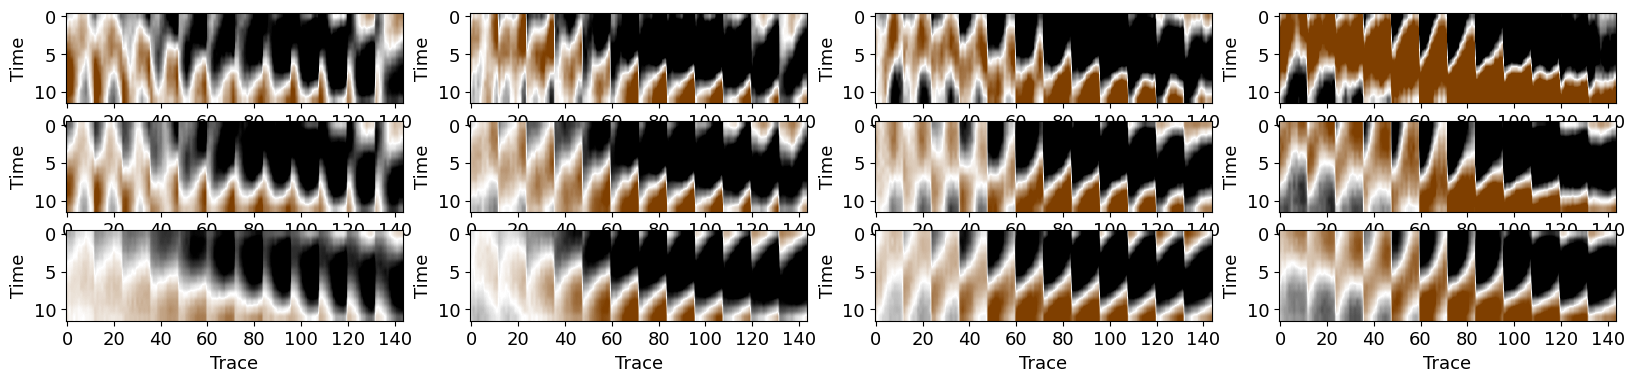

In [12]:
n = 4  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    ax1 = plt.subplot(3, n, i + 1)
    plt.imshow(out1[i].reshape(12, 12*12),cmap=cseis(),clim=(-0.1,0.1), aspect='auto');
    #plt.gray()
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xlabel('Trace',size=13)
    plt.ylabel('Time',size=13)

    ax2 = plt.subplot(3, n, i + 1 +n)
    plt.imshow(out2[i].reshape(12, 12*12),cmap=cseis(),clim=(-0.1,0.1), aspect='auto');
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xlabel('Trace',size=13)
    plt.ylabel('Time',size=13)
    
    ax3 = plt.subplot(3, n, i + 1 +2*n)
    plt.imshow(out3[i].reshape(12, 12*12),cmap=cseis(),clim=(-0.1,0.1), aspect='auto');
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.xlabel('Trace',size=13)
    plt.ylabel('Time',size=13)
#plt.savefig('./out.png',dpi=1000)
plt.show()

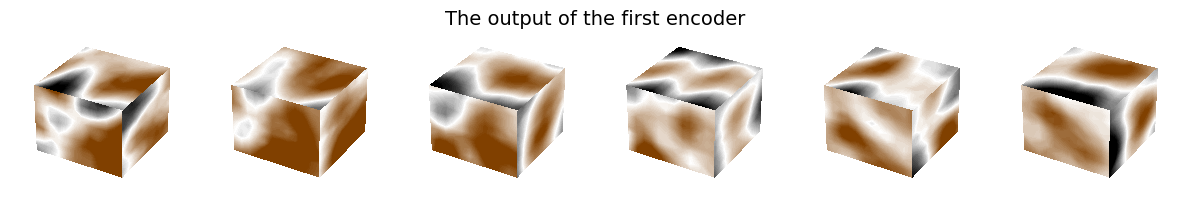

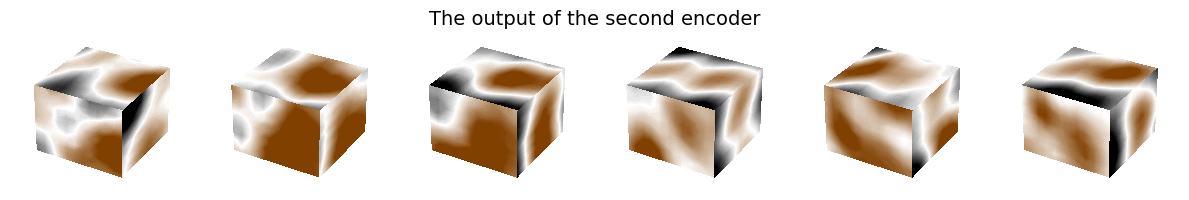

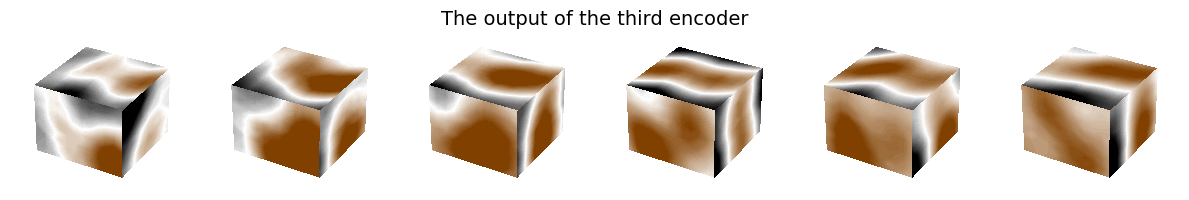

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 2))
for ii in range(6):
    ax = plt.subplot(1, 6, ii + 1, projection='3d')
    plot3d(out1[600 + ii, :].reshape(12, 12, 12, order='F'), ifnewfig=False, showf=False, close=False)
    ax.set_axis_off() 
ax = plt.gcf().add_subplot(111, aspect='auto');plt.gca().axis('off');plt.title("The output of the first encoder",size=14)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 2))
for ii in range(6):
    ax = plt.subplot(1, 6, ii + 1, projection='3d')
    plot3d(out2[600 + ii, :].reshape(12, 12, 12, order='F'), ifnewfig=False, showf=False, close=False)
    ax.set_axis_off() 
ax = plt.gcf().add_subplot(111, aspect='auto');plt.gca().axis('off');plt.title("The output of the second encoder",size=14)
plt.tight_layout()
plt.show()

# Denoised patches
plt.figure(figsize=(12, 2))
for ii in range(6):
    ax = plt.subplot(1, 6, ii + 1, projection='3d')
    plot3d(out3[600 + ii, :].reshape(12, 12, 12, order='F'), ifnewfig=False, showf=False, close=False)
    ax.set_axis_off() 
ax = plt.gcf().add_subplot(111, aspect='auto');plt.gca().axis('off');plt.title("The output of the third encoder",size=14)
plt.tight_layout()
plt.show()
